##### Copyright 2020 The TensorFlow Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License"); { display-mode: "form" }
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Chapter 3 - Sampling the Imaginary

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/probability/examples/statistical_rethinking/notebooks/03_sampling_the_imaginary"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/probability/blob/master/tensorflow_probability/examples/statistical_rethinking/notebooks/03_sampling_the_imaginary.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/statistical_rethinking/notebooks/03_sampling_the_imaginary.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/probability/examples/statistical_rethinking/notebooks/03_sampling_the_imaginary.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

## Imports and utility functions


In [2]:
#@title Install { display-mode: "form" }
TF_Installation = 'System' #@param ['TF Nightly', 'TF Stable', 'System']

if TF_Installation == 'TF Nightly':
  !pip install -q --upgrade tf-nightly
  print('Installation of `tf-nightly` complete.')
elif TF_Installation == 'TF Stable':
  !pip install -q --upgrade tensorflow
  print('Installation of `tensorflow` complete.')
elif TF_Installation == 'System':
  pass
else:
  raise ValueError('Selection Error: Please select a valid '
                   'installation option.')

In [3]:
#@title Install { display-mode: "form" }
TFP_Installation = "System" #@param ["Nightly", "Stable", "System"]

if TFP_Installation == "Nightly":
  !pip install -q tfp-nightly
  print("Installation of `tfp-nightly` complete.")
elif TFP_Installation == "Stable":
  !pip install -q --upgrade tensorflow-probability
  print("Installation of `tensorflow-probability` complete.")
elif TFP_Installation == "System":
  pass
else:
  raise ValueError("Selection Error: Please select a valid "
                   "installation option.")

In [4]:
#@title Install { display-mode: "form" }

# Install packages that are not installed in colab
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
    print("Installing arviz ...")
    !pip install -q arviz

In [5]:
# Core
import numpy as np
import arviz as az
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
import scipy.stats as stats

# visualization 
import matplotlib.pyplot as plt

# aliases
tfd = tfp.distributions

In [6]:
az.style.use('seaborn-colorblind')

# Introduction

We are interested in a blood test that correctly detects vampirisim 95% of time:

$Pr(Positive|Vampire)$ = 0.95

The test has a false positive rate of:

$Pr(Positive|Mortal)$ = 0.01

We also know that vampires are rare--about 0.1% of population:

$Pr(Vampire)$ = 0.001

To compute $Pr(Vampire|Positive)$ we will apply the Bayes' rule:

$Pr(Vampire|Positive) = \frac{Pr(Positive|Vampire) * Pr(Vampire)}{Pr(Positive)}$

##### Code 3.1

In [7]:
Pr_Positive_Vampire = 0.95
Pr_Positive_Mortal = 0.01
Pr_Vampire = 0.001
tmp = Pr_Positive_Vampire * Pr_Vampire
Pr_Positive = tmp + Pr_Positive_Mortal * (1 - Pr_Vampire)
Pr_Vampire_Positive = tmp / Pr_Positive
Pr_Vampire_Positive

0.08683729433272395

This result shows that there is only 8.7% chance that suspect is vampire even if the test is positive, because of the low incidence rate (prior probability).

## 3.1 Sampling from a grid-approximate posterior

##### Code 3.2

Let's compute the posterior for the globe tossing model, the probability of *p* conditional on the data: 

In [8]:
p_grid = tf.linspace(start=0., stop=1., num=1000)
prob_p = tf.repeat(1., 1000)
prob_data = tfd.Binomial(total_count=9, probs=p_grid).prob(6)
joint_prob = prob_data * prob_p
posterior = joint_prob / tf.reduce_sum(joint_prob)



We now wish to draw 10000 samples from the posterior :

##### Code 3.3

In [9]:
samples = tfd.Categorical(probs=posterior).sample(10_000)

Now let's display the resulting samples:

##### Code 3.4



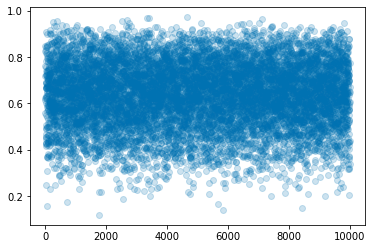

In [10]:
sample_rows = p_grid.numpy()[samples]
plt.scatter(range(len(sample_rows)), sample_rows, alpha=0.2);

As the plot shows, there are many samples in the 0.6 region and very few below 0.25.


Here's the density estimate of these samples, which is very similar to the ideal posterior you computed via grid approximation in Chapter 2, section 2.4.3.

##### Code 3.5


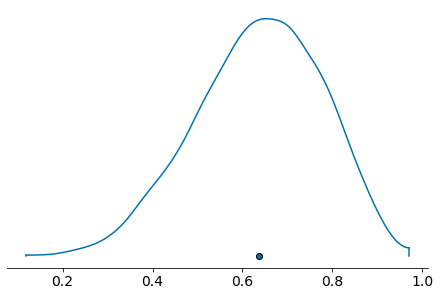

In [11]:
az.plot_density({"": sample_rows}, hdi_prob=1);

## 3.2 Sampling to summarize

Once we have the posterior distribution the next step is to summarize it. Some of the common tasks are:

>* How much posterior probability lies below some parameter value?
* How much posterior probability lies between two parameter values?
* Which parameter value marks the lower 5% of the posterior probability?
* Which range of parameter values contains 90% of the posterior probability? 
* Which parameter value has highest posterior probability?

>These simple questions can be usefully divided into questions about (1) intervals of defined boundaries, (2) questions about intervals of defined probability mass, and (3) questions about point estimates. We’ll see how to approach these questions using samples from the posterior.

### 3.2.1 Intervals of defined boundaries

What is the posterior probability that proportion of water is less than 0.5?  We can simply sum all of the probabilities where the parameter value is less than 0.5.

Let's add up the posterior probability where p < 0.5:

##### Code 3.6



In [12]:
tf.reduce_sum(posterior[p_grid < 0.5])

<tf.Tensor: shape=(), dtype=float32, numpy=0.1718746>

This means that about 17% of posterior probability is below 0.5.


Now let's find the frequency of parameter values below 0.5:

##### Code 3.7



In [13]:
tf.where(sample_rows < 0.5).shape[0] / 10_000

0.1699

This is nearly the same answer as that of grid approximation, in Code 3.6,

Using the same approach, how much posterior probability lies between 0.5 and 0.75?

##### Code 3.8


In [14]:
condition = (sample_rows > 0.5) & (sample_rows < 0.75)
tf.where(condition == True).shape[0] / 10_000

0.6042

### 3.2.2 Intervals of defined mass

Scientific journals will commonly report on an "interval of defined mass" also known as a *Confidence Interval*. The text will use the term *Compatiblity Interval* instead, since the interval indicates a range of parameter values *compatible* with the model and data.

If we want to know what interval of parameter values contains 80% of the probability mass, we can simply examine the samples from the posterior, with an interval starting at *p*=0 until we have reached the 80th percentile.

##### Code 3.9



In [15]:
tfp.stats.percentile(sample_rows, q=80.)

<tf.Tensor: shape=(), dtype=float32, numpy=0.7617617>


Similarly, the middle 80% interval lies between the 10th percentile and the 90th percentile:

##### Code 3.10


In [16]:
tfp.stats.percentile(sample_rows, q=[10.,90.])

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.44744745, 0.8128128 ], dtype=float32)>

The text refers to intervals like this, which assign equal probability mass to each tail, as *Percentile Intervals*. They can be useful to characterize a distribution if it is fairly symmetrical. 

By contrast, consider a highly skewed distribution with a maximum value at *p*=1, like the posterior for observing three waters in three tosses with a uniform prior. We can compute this posterior using grid approximation:

##### Code 3.11



In [17]:
p_grid = tf.linspace(start=0., stop=1., num=1000)
prior = tf.repeat(1., 1000)
likelihood = tfd.Binomial(total_count=3, probs=p_grid).prob(3)
joint_prob = likelihood * prior
posterior = joint_prob / tf.reduce_sum(joint_prob)

samples = tfd.Categorical(probs=posterior).sample(10_000)
sample_rows = p_grid.numpy()[samples]

Let's compute a 50% percentile compatibility interval that provides the central 50% probability by assigning 25% of the probability below the interval, and 25% above it:

##### Code 3.12



In [18]:
tfp.stats.percentile(sample_rows, q=[25.,75.])

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.7057057, 0.9309309], dtype=float32)>

Given the assymetric shape of the distribution, this interval is misleading because it fails to contain the most probable parameter values at *p*=1.


The *Highest Posterior Density Interval* (HPDI) is the narrowest interval containing the specified probability mass, which always contains the most probable parameter value.

We can use arviz to compute it:

##### Code 3.13



In [19]:
az.hdi(sample_rows, hdi_prob=0.5)

array([0.8398398, 0.998999 ], dtype=float32)

### 3.2.3 Point Estimates

How can we use the posterior distribution to create a point estimate to summarize the distribution for getting three waters from three tosses? Let's compare three different types of point estimates.

##### Code 3.14

The *maximum a posteriori* (MAP) estimate is the parameter value with the high posterior probability.

In [20]:
p_grid[posterior == max(posterior)]

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>





With our samples from the posterior, we can approximate the MAP:
##### Code 3.15



In [21]:
# to obtain mode (maximum) we use q=100.
tfp.stats.percentile(sample_rows, q=100.)

<tf.Tensor: shape=(), dtype=float32, numpy=1.0>

We can also compute the posterior mean and median.

##### Code 3.16





In [22]:
median = tfp.stats.percentile(sample_rows, q=50.)

mean = tf.math.reduce_mean(sample_rows)

print(f"median={median}, mean={mean}")

median=0.8408408164978027, mean=0.8003324866294861


We can use a loss function to compute the cost of using any specific point estimate. Suppose our loss function is proportional to the difference between our decision (e.g., our point estimate) and the true value of the parameter.

If we chose *p*=0.5 as our decision for the parameter value, we can use the posterior distribution to compute the expected loss, by computing the weighted average loss: We weight each loss by its corresponding posterior probability:


##### Code 3.17



In [23]:
tf.reduce_sum(posterior * abs(0.5 - p_grid))

<tf.Tensor: shape=(), dtype=float32, numpy=0.31287518>

We can repeat this loss computation for every possible decision:
##### Code 3.18



In [24]:
loss = list(map(lambda d: tf.reduce_sum(posterior * np.abs(d - p_grid)), p_grid))

##### Code 3.19

Now, we can find the parameter value that minimizes the loss.

In [25]:
p_grid[tf.math.argmin(loss)]

<tf.Tensor: shape=(), dtype=float32, numpy=0.8408408>

It turns out that the value that minimizes our loss will be the same as that for the posterior median, which splits the posterior density so that half the mass is above it, with half below it.

## 3.3 Sampling to simulate prediction


We can use our Bayesian models to produce simulated observations, since all Bayesian models are generative.

### 3.3.1 Dummy data

>We will call such simulated data *dummy data*, to indicate that it is a stand-in for actual data.

Recall from the globe tossing model that the probability of observing *W* counts of water in *N* tosses with proportion of water *p* is given by the binomial likelihood:

$Pr(W|N,p) = \frac{N!}{W!(N-W)!}p^W(1-p)^{N-W}$

For two tosses of the globe and proportion of water at 0.7 we can compute the probability of observing 0, 1, and 2 counts of water:

##### Code 3.20

In [26]:
tfd.Binomial(total_count=2, probs=0.7).prob(np.arange(3))

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.09      , 0.42000002, 0.48999998], dtype=float32)>

This means that there’s a 9% chance of observing *w* = 0, a 42% chance of *w* = 1, and a 49% chance of *w* = 2.

We can simulate a dummy observation of *W* from our model by sampling from the binomial distribution:

##### Code 3.21



In [27]:
tfd.Binomial(total_count=2, probs=0.7).sample()

<tf.Tensor: shape=(), dtype=float32, numpy=2.0>

The result is the number of water observations in 2 tosses of the globe.

A set of 10 simulations can be made by:

##### Code 3.22



In [28]:
tfd.Binomial(total_count=2, probs=0.7).sample((10,))

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([2., 2., 1., 0., 1., 1., 1., 1., 2., 2.], dtype=float32)>


When we generate 100,000 dummy observations, note that each value of *w* appears in proportion to its likelihood

##### Code 3.23


In [29]:
dummy_w = tfd.Binomial(total_count=2, probs=0.7).sample((100000,))

# numpy equivalent is -
# np.unique(dummy_w.numpy(), return_counts=True)[1] / 1e5
#
# Note for tensorflow we have to cast with tf.float32 to be able to divide
# and it does not sort it and hence with tf it is bit more involved
tf.sort(tf.cast(tf.unique_with_counts(dummy_w)[2], dtype=tf.float32) / 1e5)

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.09084, 0.41871, 0.49045], dtype=float32)>

>Only two tosses of the globe isn’t much of a sample, though. So now let’s simulate the same sample size as before, 9 tosses.

##### Code 3.24





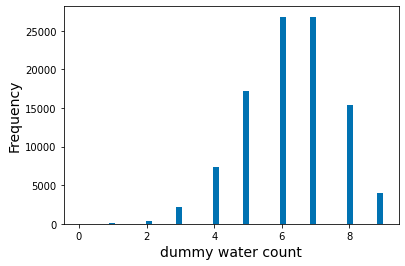

In [30]:
dummy_w = tfd.Binomial(total_count=9, probs=0.7).sample((100000,))
plt.hist(dummy_w.numpy(), bins=50)
plt.xlabel("dummy water count", fontsize=14)
plt.ylabel("Frequency", fontsize=14);

### 3.3.2. Model Checking

>We’d like to propagate the parameter uncertainty—carry it forward—as we evaluate the implied predictions. All that is required is averaging over the posterior density for *p*, while computing the predictions. For each possible value of the parameter *p*, there is an implied distribution of outcomes. So if you were to compute the sampling distribution of outcomes at each value of *p*, then you could average all of these prediction distributions together, using the posterior probabilities of each value of *p*, to get a POSTERIOR PREDICTIVE DISTRIBUTION.

To simulate predicted observations for nine globe tosses, for a single value of *p*=0.6, we can use `Binomial` to generate random binomial samples:



##### Code 3.25

In [31]:
w = tfd.Binomial(total_count=9, probs=0.6).sample(1e4)
print (w)

tf.Tensor([3. 3. 4. ... 6. 5. 5.], shape=(10000,), dtype=float32)


>All you need to propagate parameter uncertainty into these predictions is replace the value 0.6 with samples from the posterior.... Since the sampled values appear in proportion to their posterior probabilities, the resulting simulated observations are averaged over the posterior.

##### Code 3.26

In [32]:
w = tfd.Binomial(total_count=9, probs=sample_rows).sample()
print (w)

tf.Tensor([9. 5. 8. ... 8. 8. 6.], shape=(10000,), dtype=float32)
